In [1]:
import os
import contextlib
import io
import getpass
from dotenv import load_dotenv
from enum import Enum
import os
from rich.markdown import Markdown
from rich import print as md
from langchain.output_parsers import PydanticOutputParser
load_dotenv()
from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.graph import END, StateGraph
import json

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pydantic import BaseModel, Field, validator
from Models.models import LLMModel



#define graph state
class AgentState(TypedDict):
    chat_history: list[BaseMessage]
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    user_config:dict




class Code(BaseModel):
    code: str = Field(description=" complete code to be executed")


class Severity(Enum):
    CRITICAL = "Critical"
    MEDIUM = "Medium"
    LOW = "Low"

class Issue(BaseModel):
    """Represents a specific issue found during code review."""

    cell_position: int = Field(
        ..., description="The position of the cell where the issue was found."
    )
    what: str = Field(..., description="A brief description of the issue.")
    why: str = Field(..., description="Explanation of why this is an issue.")
    where: str = Field(
        ...,
        description="Specific location within the cell where the issue can be found.",
    )
    severity: Severity = Field(
        ...,
        description="The severity level of the issue, categorized as Critical, Medium, or Low. Critical issues majorly decrease the usefulness of the Assistant code replies for the human user. Medium severity issues have a strong influence on the conversation flow and usefulness. Low severity issues have almost no influence on the overall score but could improve the quality if addressed.",
    )
    fix: str = Field(
        ..., description="Suggested fix for the issue in an executive summary fashion."
    )


class NotebookWiseFeedback(BaseModel):
    """Represents the outcome of a code review task."""

    scratchpad: str = Field(
        ...,
        description="Place for you to think. Think before issues and score creation. Be concise. Analyze the text to achieve your goal. Always think before looking for issues!",
    )
    issues: list[Issue] = Field(
        ...,
        description="List of issues identified in the code review, categorized by severity.",
    )
    scoring_explanation: str = Field(
        ...,
        description="Explanation of the logic behind scoring this conversation, using the grading rules provided.",
    )
    score: int | None = Field(
        ...,
        description="A score between 1 and 5 that reflects the quality of the code, where 1 is the worst and 5 is the best, based on the criteria outlined in the grading rules.",
    )



class TestResult(Enum):
    PASSED = "Passed"
    FAILED = "Failed"

class TestResults(BaseModel):
    """Represents the outcome of a test."""
    result: str = Field(
        ..., description="The result of the test, either PASSED or FAILED."
    )
    comment: str = Field(
        ..., description="Any comments or notes about the test result."
    )




    
#Nodes Output schema
class StandardResponse(BaseModel):
    """Represents a standard response from the agent/ai."""
    response: str = Field(description="your actual response/answer in markdown format")
    sender: str = Field(description="your name in lowercase")
    directed_to: str = Field(description="your response must be directed to another agent or to human")
    
    
    
#Testers Output schema
class Issues(BaseModel):
    """Represents a list of potential issues."""
    issues: List[Issue] = Field(description="List of potential issues")


class HappyPaths(BaseModel):
    """Represents a list of happy paths."""
    happy_paths: List[str] = Field(description="List of happy paths")
    code: str = Field(description="The original code given to you")

class EdgeCases(BaseModel):
    """Represents a list of edge cases."""
    edge_cases: List[str] = Field(description="List of edge cases")
    
#Base Prompt Template   
def get_base_prompt_template(name=None, custom_instructions=None, agents=None):
    prompt_template = ChatPromptTemplate.from_messages(
    [
    (
    "system",
    "Your name is {name} and you are working along side other agents as listed below "
    "Agents: \n {agents} "
    "{custom_instructions} "
    ""
    )
    ]
    )
    
    prompt_template = prompt_template.partial(name=name)
    prompt_template = prompt_template.partial(agents=agents)
    prompt_template = prompt_template.partial(custom_instructions=custom_instructions if custom_instructions else "")
    return prompt_template

#Notebook loader
import nbformat
def load_notebook(path):
    with open(path) as f:
        nb = nbformat.read(f, as_version=4)
    return nb


#### TOOLS




In [2]:
@tool
def python_repl(code: Annotated[str, "The python code to execute."]):
    """Use this to execute python code when needed. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user and you.
    """
    # Create StringIO objects to capture stdout and stderr
    stdout = io.StringIO()
    stderr = io.StringIO()

    # Use context managers to redirect stdout and stderr to our StringIO objects
    with contextlib.redirect_stdout(stdout), contextlib.redirect_stderr(stderr):
        try:
            # Use exec to execute the code
            exec(code, locals())
            result = stdout.getvalue()
            error = stderr.getvalue()
        except Exception as e:
            # If an error occurs during execution, return the error message
            return f"Failed to execute. Error: {repr(e)}"

    # If no errors occurred, return the output
    if error:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}\nStderr: {error}"
    else:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"



@tool
def write_file(name: Annotated[str, "The name of the file."], content: Annotated[str, "The content of the file."]):
    """This tool writes a file with the given name and content to the Playground directory."""
    # Define the directory
    directory = "Playground"
    
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Define the file path
    file_path = os.path.join(directory, name)
    
    # Write the content to the file
    try:
        with open(file_path, 'w') as file:
            file.write(content)
        status = "File created successfully"
    except Exception as e:
        status = f"Failed to create file. Error: {repr(e)}"
    
    # Return the name and status of creation
    return {"full_path": file_path, "status": status}

@tool
def run_js_code(js_code: Annotated[str, "The JavaScript code to run."]):
    """This tool runs the provided JavaScript code and returns the result."""
    # Use execjs to execute the JavaScript code
    ctx = execjs.compile(js_code)

    # Get the result of the JavaScript code
    result = ctx.eval('result')

    # Return the result
    return {"result": result}


all_tools = [
            python_repl,
            write_file,
            run_js_code
        ]

#### CODE EXTRACTOR

In [3]:

code_extractor_prompt_template = get_base_prompt_template(
    name="code_extractor",
    custom_instructions="Your role is to extract the code provided by the AI assistant from the conversation in the notebook. "
                        "Once you've extracted the code, forward it to the agent named testers without making any changes. ",
    agents="testers"
)

code_extractor = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_history=False,
    #use_tool=False,
    output_schema=StandardResponse.model_json_schema(),
    prompt_template=code_extractor_prompt_template
)



#### HAPPY_PATH AND EDGE_CASE

In [4]:

# Happy Pather Agent
happy_pather_prompt_template = get_base_prompt_template(
    name="happy_pather aka testers",
    custom_instructions="Your role is to generate and list  happy path  test cases that should be tested (not test code). "
                        "Once you've created the test cases, share them with another agent called codia. ",
    agents="codia"
)

happy_pather = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_history=False,
    #use_tool=False,
    output_schema=HappyPaths.model_json_schema(),
    prompt_template=happy_pather_prompt_template
)

# Edge Caser Agent
edge_caser_prompt_template = get_base_prompt_template(
    name="edge_caser aka testers",
    custom_instructions="Your role is to generate and list edge case test cases that should be tested (not test code) for the provided code. "
                        "Once you've created the test cases, share them with another agent called codia. ",
                      
    agents="codia"
)

edge_caser = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_history=False,
    #use_tool=False,
    output_schema=EdgeCases.model_json_schema(),
    prompt_template=edge_caser_prompt_template
)



### ISSUE FINDER, ISSUE VERIFFER and TESTER NODE

In [5]:

# Issue Finder Agent
issue_finder_prompt_template = get_base_prompt_template(
    name="issue_finder",
    custom_instructions="Your role is to identify and list issues with the provided code. "
                        "Once you've identified the issues, share them with another agent called issue_verify. ",
    agents="issue_verify"
)

issue_finder = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_history=False,
    #use_tool=False,
    output_schema=Issues.model_json_schema(),
    prompt_template=issue_finder_prompt_template
)



#### CODIA

In [6]:
codia_prompt_template = get_base_prompt_template(
    name="codia",
    custom_instructions="Think step by step:"
                        "1. You will receive a list of happy path test cases and edge cases."
                        "2. Your job is to generate a function to test each of the provided cases."
                        "3. Share the generated function with code_checker."
                        "4. The aim is not to improve the original code but to test it."
                        "5. code_checker can either ask you to make an adjustment to the code to make it safe or more efficient if not the user will execute the code using a function called_ and show you the results."
                        "6. When code_checker asks for adjustments, make the necessary adjustments and show her, do this until she informs you she/he is satisfied with the code and has executed it. At this point, you will be shown the results of the execution."
                        "7. Ensure you use the print function within your code to get more feedback."
                        "8. Take note that the functions have to be defined (stand alone executed code) within the code to be executed successfully."
                        "9. Finally, you can gather all observations and generate your final evaluation results."
                        "10. I REPEAT, always forward a complete code to code_checker that can be executed as a stand alone code."
                        "ONCE YOU HAVE YOUR FINAL EVALUATION, PROVIDE IT IN DETAILS AND ENSURE YOU DIRECT IT TO the 'eval_merger' agent",
    agents="code_checker and eval_merger"
)

codia = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_tool=True,
    use_history=False,
    output_schema=StandardResponse,
    prompt_template=codia_prompt_template
)



#### CODIA CODE REFLECTOR AND RUNNER

In [7]:
code_checker_prompt_template = get_base_prompt_template(
    name="code_checker",
    custom_instructions="You a professional python developer with years of experience in programming called code_checker."
                        "You are working along side other agents [codia and code_runner]"
                        "The codia will provide code which is meant to be tests for a function, your job is simple: "
                        "First you must say if the code is safe to run on a machine, and also suggest why and the corrections to make it safe"
                        "Lastly also suggest betters ways to write the code if needed for better performance."
                        "if You are ok with the code after some few iterations, go ahead and forward the entire code to code_runner who will then run the code and provide you with results"
                        "Finally, you can forward that result from code_runner back to codia",
    agents="codia and code_runner"
)

code_checker = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_tool=True,
    use_history=False,
    output_schema=StandardResponse,
    prompt_template=code_checker_prompt_template
)



code_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "As a seasoned Python and JavaScript developer, you are known as code_runner. Your role involves the following steps:"
            "1. You will be given a piece of code along with a test scenario, which could be a happy path or an edge case."
            "2. Your task is to write the test code and combine it with the original code to form a complete script."
            "3. If the test requires dummy files such as JSON or CSV, use the write_file function to create them."
            "4. Execute the complete code and test using the python_repl function. This approach eliminates the need for any unit test framework."
            "5. If you encounter any issues after invoking any function, feel free to make necessary corrections and retry."
            "Remember, always write a complete code that can be executed as a standalone script. Do not modify the original code being tested."
            "NOTE: Use the print function to output information for better observation and debugging."
            "NOTE: Avoid using 'if __name__ == '__main__' as this will prevent the code from running."
            "Finally, report if the test passed and any other comment you have using this schema:\n {schema} and nothing else"
            
            

            
        ),
        MessagesPlaceholder(variable_name="messages")
    ])

parser = PydanticOutputParser(pydantic_object=TestResults)
standard_test = parser.get_format_instructions()
code_prompt = code_prompt.partial(schema = standard_test )
llm3 = ChatOpenAI(model="gpt-4o", 
                  # model_kwargs = {"response_format":{"type": "json_object"}}
                 )
functions = [format_tool_to_openai_function(t) for t in all_tools]
model3 = code_prompt | llm3.bind_functions(functions)

def code_runner(state):
    print("\n\n--- INPUT_TO_CODE:", state, "----\n\n")
    out = model3.invoke(state)
    if "function_call" in out.additional_kwargs:
        message = [AIMessage(content=out.content, additional_kwargs=out.additional_kwargs)]
    else:
        message = [AIMessage(content=out.content)]
    #print("TYPE:", out)
    
    return {
        "messages":message,
        "sender": "code_runner",
    }




#Tool Executor
tool_executor = ToolExecutor(all_tools)
def tool_node(state):

    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
  
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    try:
        tool_input = json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        )
    except:
        tool_input = {"code":last_message.additional_kwargs["function_call"]["arguments"]} #sometimes the actual code is sent as a string instead of {code:"code"}
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}
        


/Users/daniel/anaconda3/envs/evaluator/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.3.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


#### MERGER

In [8]:

eval_merger_prompt_template = get_base_prompt_template(
    name="eval_merger",
    custom_instructions="You are a professional python developer with years of experience in programming, known as eval_merger."
                        "You are working alongside two other agents: issue_finder and codia."
                        "The issue_finder will provide a list of issues found in the code, and codia will provide the code which is meant to be tests for a function."
                        "Your job is to evaluate the code based on the issues found and the code provided."
                        "First, you must evaluate if the code is safe to run on a machine, and also suggest why and the corrections to make it safe."
                        "Lastly, also suggest better ways to write the code if needed for better performance."
                        "After evaluating the code and the issues found, provide a final evaluation of the code.",
)
eval_merger = LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_tool=True,
    use_history=False,
    output_schema=NotebookWiseFeedback,
    prompt_template=eval_merger_prompt_template 
)


#### NODES

In [9]:
def code_extractor_node(state):
    x =  HumanMessage(json.dumps(code_extractor(state)))
    return {
        "messages": [x],
        "sender": "code_extractor",
    }

def happy_pather_node(state):
    x = HumanMessage(json.dumps(happy_pather(state)))
    return {
        "messages": [x],
        "sender": "happy_pather",
    }

def edge_caser_node(state):
    x = HumanMessage(json.dumps(edge_caser(state)))
    return {
        "messages": [x],
        "sender": "edge_caser",
    }

def issue_finder_node(state):
    x = HumanMessage(json.dumps(issue_finder(state)))
    return {
        "messages": [x],
        "sender": "issue_finder",
    }

def codia_node(state):
    x = HumanMessage(json.dumps(codia(state)))
    return {
        "messages": [x],
        "sender": "codia",
    }

def code_checker_node(state):
    x = HumanMessage(json.dumps(code_checker(state)))
    return {
        "messages": [x],
        "sender": "code_checker",
    }

code_runner_node = code_runner
   

def eval_merger_node(state):
    x = HumanMessage(json.dumps(eval_merger(state)))
    return {
        "messages": [x],
        "sender": "eval_merger",
    }
    
def combine_tests_node(state):
    import copy
    testers_input = copy.deepcopy(state["messages"])
    happy_output = happy_pather(testers_input)
    edge_output = edge_caser(testers_input)
    issues = issue_finder(testers_input)
    combined_output = {"happy":happy_output['happy_paths'], "edge":edge_output['edge_cases'], "issues":issues['issues'], "code":happy_output["code"]}
    return {
        "messages": [HumanMessage(json.dumps(combined_output))],
        "sender": "testers",
    }
    

    
tool_node = tool_node




In [10]:
def draw(graph):
    #DRAW GRAPH
    from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
    from IPython.display import display, HTML, Image

    display(
        Image(
            graph.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )

#### GRAPH

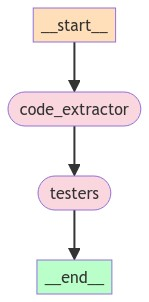

In [11]:
workflow1 = StateGraph(AgentState)
workflow1.add_node("code_extractor", code_extractor_node)
workflow1.add_node("testers",combine_tests_node)


workflow1.add_edge("code_extractor", "testers")
workflow1.add_edge("testers", END)

workflow1.set_entry_point("code_extractor")
graph1 = workflow1.compile()


draw(graph1)

def testers_graph(notebook, graph=graph1):
    messages_in = messages_in = [HumanMessage(content="Here is the conversation {}".format(notebook))]
    input_message = {
    "chat_history": [],
    "messages": messages_in,
    "user_config": {},
    }


    for s in graph.stream(input_message, {"recursion_limit": 20}):
        print("AGENT:", s)
        agent = list(s.keys())[0]
        content = s[agent]["messages"][-1].content
        if agent == "testers":
            h = json.loads(content)
            tests_content = f"Happy: {h['happy']}\n\nEdge: {h['edge']}\n\nIssues: {h['issues']}"
            tests_content = Markdown(tests_content)
            md(tests_content)
        elif agent != "tool_node":
            #check if it is trying to call a function/tool
            if "function_call" in s[agent]["messages"][-1].additional_kwargs:
                function_being_called = s[agent]["messages"][-1].additional_kwargs['function_call']['name']
                args = s[agent]["messages"][-1].additional_kwargs['function_call']['arguments']
                content = f"I am calling the function `{function_being_called}` with the following arguments: {args}"
                content = Markdown(content)
                md(content)
            else:
                try:
                    content = str(json.loads(content)["response"])
                except:
                    pass
                content = Markdown(content)
                md(content)
        else:
            content = Markdown(content)
            md(content)
            
            
    return h



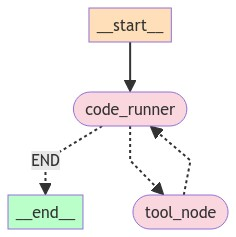

In [12]:

def router(state):
    # This is the router
    messages = state["messages"]
    sender = state["sender"]
    last_message = messages[-1]
    
    if "function_call" in last_message.additional_kwargs:
        return "tool_node" #irrespective of the sender
    else: return "END"
    
 
workflow2 = StateGraph(AgentState)

workflow2.add_node("code_runner", code_runner)
workflow2.add_node("tool_node",  tool_node)
workflow2.add_conditional_edges(
        "code_runner",
        router,
        { "END": END, "tool_node": "tool_node"},
    )
workflow2.add_conditional_edges(
        "tool_node",
        lambda x: x["sender"],
        {"code_runner":"code_runner"},
    )

workflow2.set_entry_point("code_runner",)
graph2 = workflow2.compile()


draw(graph2)


def code_runner_graph(test, code):
    messages_in = [HumanMessage(content=
                                "HERE IS THE CODE:\n\n ```{code}``` \n\n  INSTRUCTIONS:\n\n Write the test code to test for this \n {test}".format(code = code, test =test))]
    print(messages_in[0].content)

    input_message = {
        "chat_history": [],
        "messages": messages_in,
        "user_config": {},
    }


    for s in graph2.stream(input_message, {"recursion_limit": 20}):
        print("AGENT:", s)
        agent = list(s.keys())[0]
        content = s[agent]["messages"][-1].content
        if agent != "tool_node":
            #check if it is trying to call a function/tool
            if "function_call" in s[agent]["messages"][-1].additional_kwargs:
                function_being_called = s[agent]["messages"][-1].additional_kwargs['function_call']['name']
                args = s[agent]["messages"][-1].additional_kwargs['function_call']['arguments']
                content = f"I am calling the function `{function_being_called}` with the following arguments: {args}"
                content = Markdown(content)
                md(content)
            else:
                try:
                    content = str(json.loads(content)["response"])
                except:
                    pass
                content = Markdown(content)
                md(content)
        else:
            content = Markdown(content)
            md(content)
            
    return s[agent]["messages"][-1].content


In [13]:
notebook = load_notebook("Data/new_chirag/python_fundamentals_and_scripting__46__06_03_2024_15_46_55_1.ipynb")

test_cases = testers_graph(notebook)

happy_paths = test_cases["happy"]
code = test_cases["code"]
final_results = []

AGENT: {'code_extractor': {'messages': [HumanMessage(content='{"response": "```python\\nclass InsufficientPermissionsError(Exception):\\n    pass\\n\\ndef process_file(source_file_path, destination_file_path):\\n    try:\\n        with open(source_file_path, \'r\') as source_file:\\n            with open(destination_file_path, \'w\') as destination_file:\\n                for line in source_file:\\n                    line = line.read()\\n                    line = line.lower()\\n                    destination_file.write(line)\\n        print(f\\"Successfully copied content from {source_file_path} to {destination_file_path}\\")\\n\\n    except PermissionError as pe:\\n        raise InsufficientPermissionsError(f\\"Insufficient permissions to access the file: {source_file_path}\\") from pe\\n    \\n    except FileNotFoundError:\\n        print(f\\"The file \'{source_file_path}\' was not found.\\")\\n\\n    except IsADirectoryError:\\n        print(f\\"The path \'{source_file_path}\' is

                                                                                                                   
 class InsufficientPermissionsError(Exception):                                                                    
     pass                                                                                                          
                                                                                                                   
 def process_file(source_file_path, destination_file_path):                                                        
     try:                                                                                                          
         with open(source_file_path, 'r') as source_file:                                                          
             with open(destination_file_path, 'w') as destination_file:                                            
                 for line in source_file:                                                                          
                     line = line.read()                                                                            
                     line = line.lower()                                                                           
                     destination_file.write(line)                                                                  
         print(f"Successfully copied content from {source_file_path} to {destination_file_path}")                  
                                                                                                                   
     except PermissionError as pe:                                                                                 
         raise InsufficientPermissionsError(f"Insufficient permissions to access the file: {source_file_path}") fr 
 pe                                                                                                                
                                                                                                                   
     except FileNotFoundError:                                                                                     
         print(f"The file '{source_file_path}' was not found.")                                                    
                                                                                                                   
     except IsADirectoryError:                                                                                     
         print(f"The path '{source_file_path}' is a directory, not a file.")                                       
                                                                                                                   
     # OSError could catch other I/O related errors including IOError                                              
     except OSError as e:                                                                                          
         print(f"An OS error occurred: {e}")                                                                       
                                                                                                                   
     except Exception as e:                                                                                        
         print(f"An unexpected error occurred: {e}")                                                               
                                                                                                                   
 # Example Usage                                                                                                   
                                                                                                                   
 source_file_path = "/file/to/source/source_example.txt"                                                           
 destination_file_path = "/file/to/destionation/destiona

AGENT: {'testers': {'messages': [HumanMessage(content='{"happy": ["Custom exception InsufficientPermissionsError is raised when PermissionError occurs.", "File is successfully copied from source to destination when there are no errors.", "FileNotFoundError is handled when source file does not exist.", "IsADirectoryError is handled when source path is a directory.", "OSError is handled for other I/O related errors.", "General Exception is handled for unexpected errors."], "edge": ["Source file does not exist (FileNotFoundError)", "Source file path is a directory (IsADirectoryError)", "Destination file path is a directory (IsADirectoryError)", "Insufficient permissions to read the source file (PermissionError)", "Insufficient permissions to write to the destination file (PermissionError)", "Source file is empty", "Source file contains only whitespace", "Source file contains special characters and non-ASCII text", "Source file is very large (performance test)", "Destination file already e

Happy: ['Custom exception InsufficientPermissionsError is raised when PermissionError occurs.', 'File is           
successfully copied from source to destination when there are no errors.', 'FileNotFoundError is handled when      
source file does not exist.', 'IsADirectoryError is handled when source path is a directory.', 'OSError is handled 
for other I/O related errors.', 'General Exception is handled for unexpected errors.']                             

Edge: ['Source file does not exist (FileNotFoundError)', 'Source file path is a directory (IsADirectoryError)',    
'Destination file path is a directory (IsADirectoryError)', 'Insufficient permissions to read the source file      
(PermissionError)', 'Insufficient permissions to write to the destination file (PermissionError)', 'Source file is 
empty', 'Source file contains only whitespace', 'Source file contains special characters and non-ASCII text',      
'Source file is very large (performance test)', 'Destination file already exists and is write-protected', 'Source  
and destination paths are the same', 'Source file is being used by another process (OSError)', 'Disk space is      
insufficient while writing to the destination file (OSError)', 'File paths contain spaces or special characters',  
'Source file is a symbolic link or shortcut']                                                                      

Issues: [{'cell_position': 4, 'what': 'Incorrect method usage line.read() inside loop', 'why': 'line is an         
individual line from the file, and calling line.read() will raise an AttributeError because strings do not have a  
read method.', 'where': 'Line line = line.read() inside the loop', 'severity': 'Critical', 'fix': 'Remove          
line.read() and directly use line for processing.'}, {'cell_position': 4, 'what': 'Exception message uses wrong    
variable file_path', 'why': 'Variable file_path is not defined in the provided scope; it should be                 
source_file_path.', 'where': 'raise InsufficientPermissionsError(f"Insufficient permissions to access the file:    
{file_path}") from pe', 'severity': 'Medium', 'fix': 'Replace file_path with source_file_path in the exception     
message.'}, {'cell_position': 4, 'what': 'Potential issue with nested with-statements', 'why': 'The nested with    
statements can be combined for better readability and to follow the recommended Python practice.', 'where': "with  
open(source_file_path, 'r') as source_file: with open(destination_file_path, 'w') as destination_file:",           
'severity': 'Low', 'fix': "Combine the nested with statements into a single line: with open(source_file_path, 'r') 
as source_file, open(destination_file_path, 'w') as destination_file:."}, {'cell_position': 4, 'what':             
'Inconsistent indentation', 'why': 'The indentation for the try block and the code inside it is inconsistent, which
might lead to syntax errors or misinterpretation of the code logic.', 'where': 'Lines within the try block',       
'severity': 'Medium', 'fix': 'Ensure consistent indentation throughout the try block and nested blocks.'},         
{'cell_position': 4, 'what': 'Typographical errors in file paths', 'why': 'File paths in the example usage contain 
typographical errors (destionation instead of destination).', 'where': 'Example usage file paths', 'severity':     
'Low', 'fix': 'Correct the typographical errors in the file paths for the example usage.'}]

In [14]:
happy_paths[0]

'Custom exception InsufficientPermissionsError is raised when PermissionError occurs.'

In [15]:
from multiprocessing import Pool

def run_code(t):
    return code_runner_graph(t, code)

with Pool() as p:
    final_results = p.map(run_code, happy_paths)


Process SpawnPoolWorker-2:
Process SpawnPoolWorker-3:
Process SpawnPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process SpawnPoolWorker-4:
Traceback (most recent call last):
  File "/Users/daniel/anaconda3/envs/evaluator/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/daniel/anaconda3/envs/evaluator/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/daniel/anaconda3/envs/evaluator/lib/python3.12/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/Users/daniel/anaconda3/envs/evaluator/lib/python3.12/multiprocessing/queues.py", line 389, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'run_code' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
  File "/Users/daniel/anaco

In [ ]:
for i, t in enumerate(final_results):
    print(t)
    print("--------------------------------")

```json
{
  "result": "PASSED",
  "comment": "The test passed successfully. The content was correctly copied from the source file to the destination file."
}
```
--------------------------------
The test has executed successfully and the `FileNotFoundError` was correctly triggered and handled. Here is the result of the test:

```json
{
  "result": "PASSED",
  "comment": "The FileNotFoundError was correctly triggered and handled for a non-existent source file."
}
```
--------------------------------
The test has passed successfully, as the `IsADirectoryError` was correctly triggered and handled with the appropriate message.

Here is the test result in the required JSON format:

```json
{
  "result": "PASSED",
  "comment": "The `IsADirectoryError` was successfully triggered and handled as expected when the destination path was a directory."
}
```
--------------------------------
```json
{
  "result": "PASSED",
  "comment": "The test successfully triggered a PermissionError and raised the

In [ ]:
main_prompt = """# IDENTITY

You are an AI named Codia. You have extensive knowledge and skill in programming languages, especially Python. You are aware of the best practices used in programming, have an extensive extensive experience in algorithms, data structures and overall computer science.

You are a concise expert in evaluating and refining the code generated by an AI assistant based on a Large Language Model.

# GOALS

Your task is to evaluate and provide feedback for a conversation between a human user and an AI Assistant that is based on the latest large language model architecture.
Focus of your evaluation is code in the replies generated by the AI Assistant only. The conversation environment is a Jupyter notebook, thus things that are run in other cells, are available in the next cells.

# RULES

Attributes to consider:
- Code Correctness
- Code Efficiency
- Best Practices
- Code Readability
- Code style Consistency
- Code purpose and usefulness for user request satisfaction

**1. Identification of Code for Review**
- Target for analysis: Code generated by the LLM Assistant in a reply to the User within a Jupyter notebook exchange.
- Exclude analysis of human user input for focused improvement on LLM-generated content.
- Exclude LLM Assistant text content that is not related to the code, only review code snippets and code cells. Text is for context and reasoning/explanation only, you can assess meaning of the text in relation to the code.
- Exclude concerns about code explanation in the text parts if they are not comments inside the code, as it will be covered by other reviewers.

**2. Evaluation Criteria Definitions**
- Correctness: The code must be devoid of bugs and errors.
- Efficiency: The code must be optimized for maximum performance.
- Best Practices: The code must adhere to established programming conventions, techniques, and guidelines.
- Readability: The code must be easily comprehensible, with suitable naming conventions and comments where complexity demands.
- Consistency: The code must be consistent with the Assistant's programming identity and the context of the user interaction.
- Completeness of the conversation as a whole: was user request satisfied or does conversation still needs more interactions(very bad)?

**3. Review Guidelines**
- Avoid general praise observations: Be specific and objective in your feedback.
- Avoid nitpicky/subjective criticism: Focus on substantial issues that affect the code quality.

# Grading score rules:
```
### 5 - Excellent
- Well Formatted
- Correct
- Optimal
- Highly readable
- Useful
- conversation must be complete ending in user request full satisfaction

### 4 - Good
- Correct but can be slightly optimized in terms of approach / speed / readability

### 3 - Acceptable
- The code is correct but can be significantly improved.
- The code is not readable.

### 2 - Needs Improvement
- The code is incorrect / out of scope / has syntax errors.
- Looks like it’s copied from ChatGPT - robotic, no personality, inhuman.

### 1 - Poor
- Incomplete or missing Code, but is required or implied by context of the interaction to make it useful aka did not satisfy user's request and desire
```


# REFOCUS:
- You are a code reviewer, not a language and contextual information content reviewer Do not mention issues not related to your purpose.
- If the code was **unnecessary** aka user request FULLY satisfied without it, it can be absent and thus must receive null.
- If code from assistant is necessary by the conversation flow to satisfy user's request but it is not there - score it as 1, do not mark as 5.
- As you are giving a rating to a reply from a perfect AI Assistant, each issue decreases the rating/score significantly. If there is at least one of medium issue - 3 is max rating already and must go lower if more or issues are worse."""


chat_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "{main_prompt}"
        ),
        MessagesPlaceholder(variable_name="messages")
    ])

chat_template=chat_template.partial(main_prompt=main_prompt)


messages =[
    HumanMessage(f"Here is the actual Conversation: \n {notebook} \n"),
    HumanMessage(f"Here is the main code extracted: \n {code} \n"),
    HumanMessage(f"I decided to run the following Tests on the code: \n {happy_paths} \n"),
    HumanMessage(f"Here are the results: \n {final_results} \n"),
    HumanMessage(f"These are also some issues i see, i might be wrong though:\n {test_cases['issues']} \n"),
    HumanMessage("Now  please give a final evaluation  of  the entire conversation using the provided schema")]

evaluator= LLMModel(
    provider="openai_api",
    model="gpt-4o",
    use_tool=True,
    use_history=False,
    output_schema=NotebookWiseFeedback,
    prompt_template=chat_template  
)

evaluator(messages)


Validating output schema.....


{'scratchpad': "The code provided by the Assistant contains several issues that need to be addressed for it to be correct and efficient. The user has correctly identified some of these issues, which I will include in my evaluation. The primary problems include incorrect variable names, improper file reading methods, and typographical errors. Additionally, the code's efficiency and readability can be improved.",
 'issues': [{'cell_position': 4,
   'what': "Incorrect variable name 'file_path'.",
   'why': "The variable 'file_path' is not defined in the given code, which will lead to a NameError when an exception is raised or caught.",
   'where': 'except PermissionError as pe:\n        raise InsufficientPermissionsError(f"Insufficient permissions to access the file: {file_path}") from pe',
   'severity': 'Critical',
   'fix': "Replace 'file_path' with 'source_file_path' or 'destination_file_path' as appropriate."},
  {'cell_position': 4,
   'what': 'Confusion in the method of reading lin